In [3]:
import pandas as pd
import numpy as np
import tweepy
import re
import json

# Gather

In [45]:
dogs = pd.read_csv('twitter-archive-enhanced.csv')

In [46]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
breeds = pd.read_csv(url, sep = '\t')

In [5]:
consumer_key = 'nU7frmuxMeLqQOTYJqc2SrnAT'
consumer_secret = 'JH1bzps6IChz7wkq5gNJjAeQSGYEzlIvEY8YiCoaNyGVnMupst'

access_token = '775727712291975168-jg4QdBeRynLnp5YfW9PjPdGfjxDU293'
access_token_secret = '7sBwYUhqnesBHMpTWoa8StLlwo3cbSq6jIMNa3P3dAV0v'

In [6]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify= True)

In [47]:
tweet_id_list = list(dogs.tweet_id)

In [ ]:
#write to file and read back to avoid long query times (query limit by twitter API)
tweet_list = list()

for tweet_id in tweet_id_list:
    try:
        tweet = api.get_status(str(tweet_id), tweet_mode='extended')
        tweet_list.append(tweet._json)
        print(tweet_id_list.index(tweet_id))
    except:
        print("Failure:", tweet_id_list.index(tweet_id))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
Failure: 19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


In [ ]:
#write json to file - one entry per line
with open('tweet_json.txt', mode = 'w') as f:
    for tweet in tweet_list:
        f.write(json.dumps(tweet)+'\n')

In [77]:
#read in desired attributes to a dictionary
dict_list = list()
with open('tweet_json.txt', 'r') as tweet_json:
    for _ in range(len(tweet_id_list) - 5):
        line = tweet_json.readline()
        tweet = json.loads(line)
        dict_list.append({
            'tweet_id': tweet['id'],
            'time': tweet['created_at'],
            #this is a hack to access sub dictionary using .get()
            'media_type': tweet['entities'].get('media', [{}])[0].get('type', np.NaN),
            'favorite_count': tweet['favorite_count'],
            'retweet_count': tweet['retweet_count'],
        })

In [49]:
#read dictionary to df
tweet_scraped = pd.DataFrame(dict_list)

# Assess

In [50]:
dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [ ]:
dogs

In [ ]:
dogs.rating_denominator.value_counts()
dogs[dogs.rating_denominator != 10].shape[0]

In [ ]:
dogs.rating_numerator.value_counts().sort_index(ascending = False)

In [ ]:
dogs[dogs.rating_numerator >=20][['text','timestamp','rating_numerator']]

In [ ]:
#see if more than one stage per picture
def get_class(text):
    count = 0
    if re.search("[Dd]oggo", text):
        count += 1
    if re.search("[Ff]loofer", text):
        count += 1
    if re.search("[Pp]upper", text):
        count += 1
    if re.search("[Pp]uppo", text):
        count += 1
    return count

dogs.text.apply(get_class).value_counts()

In [ ]:
breeds.info()

In [ ]:
breeds

In [ ]:
breeds[breeds.p1_conf <= 0.5].shape[0]

In [ ]:
tweet_scraped.info()

In [ ]:
tweet_scraped

### dogs
- `retweeted_status_id` - Some are retweets
- `timestamp` doesn't have week day
- May have bad info in stage columns (see project instructions) 
    - check for floof
- stage [doggo, pupper, etc.] is in four columns
    - come pictures contain more than one so cannot condense to categorical value
- `name` - some pictures have more than one dog, but there is only one name in the column
- tweet_id is number - should be string
- `rating_numerator` - some very high values (> 20)
    - 1776 on July 4th American Independence Day
    - 420 is a snoop dog pun
    - 666 is a bad dog pun
    - 182 is a blink 182 reference
    - large numbers are sometimes sum scores of groups
    - Anything above 20 occurs only once of close to once
    - can use to see if puns have response?
- `rating_numerator` - 23 values != 10
    - often a sum for multiple dogs in a picture
- `timestamp` should be in datetime
- undescriptive column names (need code book)

### breeds

1. missing values (~300)compared to dogs
- `tweet_id` in int not str
2. `img_num` - some have more than one image 
3. `p1` - names are objects not categories
- `p1` - some are uppercase, some are lowercase
4. `p1_conf` - some probabilites are low (836 < 0.5)
5. `p1_dog` - some entries are not dogs (confirmed by looking at pictures)
    - EDA: Do people like non-dog posts more/less than dog posts?
- `p1_dog` - not boolean
    - cannot make boolean without coercing NaN value to True
6. Note: all tweet_ids are in dogs table and there are no duplicate values

### tweet_scraped

1. Some entries don't have photos (want only entries with photos)
-  missing some data where tweet_ids were invalid 
- `time` not in datetime format
- `tweet_id` int not str

   ## Tidiness
- tweet_metrics should be part of dogs table
- breeds `p1` should be a part of dogs table (but maybe at a confidence threshold?)
- more than one observational type per table

# Clean

In [51]:
dogs_clean = dogs.copy()
breeds_clean = breeds.copy()
tweet_scraped_clean = tweet_scraped.copy()

### **tweet_scraped should be part of dogs table**

Define: Merge tables on tweet_id

In [52]:
dogs_clean = pd.merge(dogs_clean, tweet_scraped_clean, on = 'tweet_id', how='left')

In [53]:
#test
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 21 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorite_count                23

### breeds `p1` and `p1_dog` should be a part of dogs table (but maybe at a confidence threshold?)

**Define:** Merge breeds p1 into dogs_clean if p1_conf > 0.5

In [54]:
dogs_clean = pd.merge(dogs_clean, breeds[breeds.p1_conf > 0.5][['tweet_id','p1', 'p1_dog']], on = 'tweet_id', how = 'left')

In [55]:
#test
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 23 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorite_count                23

 ### Some entries don't have photos (want only entries with photos)
 
 **Define:** Drop rows without photos (media_type == NaN)

In [56]:
dogs_clean = dogs_clean[dogs_clean.media_type.notnull()]

In [57]:
#test
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2355
Data columns (total 23 columns):
tweet_id                      2072 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2072 non-null object
source                        2072 non-null object
text                          2072 non-null object
retweeted_status_id           78 non-null float64
retweeted_status_user_id      78 non-null float64
retweeted_status_timestamp    78 non-null object
expanded_urls                 2072 non-null object
rating_numerator              2072 non-null int64
rating_denominator            2072 non-null int64
name                          2072 non-null object
doggo                         2072 non-null object
floofer                       2072 non-null object
pupper                        2072 non-null object
puppo                         2072 non-null object
favorite_count                2072 

### `retweeted_status_id` - Some are retweets (don't want retweets)

**Define:** Drop rows that are tweets and drop retweeted columns

In [58]:
dogs_clean = dogs_clean[dogs_clean.retweeted_status_id.isnull()]

In [59]:
dogs_clean.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis = 1, inplace = True)

In [60]:
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
favorite_count           1994 non-null float64
media_type               1994 non-null object
retweet_count            1994 non-null float64
time                     1994 non-null object
p1                       1186 non-null object
p1_dog                

### `timestamp` doesn't have week day

**Define:** Drop in favor of time downloaded from twitter api

In [61]:
dogs_clean.drop(['timestamp'], axis = 1, inplace = True)

In [62]:
#test
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
favorite_count           1994 non-null float64
media_type               1994 non-null object
retweet_count            1994 non-null float64
time                     1994 non-null object
p1                       1186 non-null object
p1_dog                   1186 non-null object
dtypes: float64(4), in

### May have bad info in stage columns (see project instructions) 

**Define:**Get new data from text using regex

In [63]:
dogs_clean.doggo = dogs_clean.text.str.contains('[Dd]oggo')
#this is a special regex based on the weratedogs classification provided
dogs_clean.floofer = dogs_clean.text.str.contains('[Ff]loof')
dogs_clean.pupper = dogs_clean.text.str.contains('[Pp]upper')
dogs_clean.puppo = dogs_clean.text.str.contains('[Pp]uppo')

In [64]:
#test
for stage in ['doggo', 'floofer','pupper','puppo']:
    print(stage + ": ", dogs_clean[stage].sum())

dogs_clean.info()

doggo:  80
floofer:  37
pupper:  235
puppo:  29
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null bool
floofer                  1994 non-null bool
pupper                   1994 non-null bool
puppo                    1994 non-null bool
favorite_count           1994 non-null float64
media_type               1994 non-null object
retweet_count            1994 non-null float64
time                     1994 non-null object
p1                       1186 non-null object
p1_dog                   118

### `time` not in datetime format

**Define:** Change format

In [65]:
#this is a work around because to_datetime does not support %z utc offset
def drop_utc(time):
    time_list = time.split(' ')
    new_time = time_list[0:4]
    new_time.append(time_list[-1])
    return ' '.join(new_time)

dogs_clean.time = dogs_clean.time.apply(drop_utc)

In [66]:
dogs_clean.time = pd.to_datetime(dogs_clean.time, format = "%a %b %d %H:%M:%S %Y", utc=True)

In [75]:
#test
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null bool
floofer                  1994 non-null bool
pupper                   1994 non-null bool
puppo                    1994 non-null bool
favorite_count           1994 non-null float64
media_type               1994 non-null object
retweet_count            1994 non-null float64
time                     1994 non-null datetime64[ns]
p1                       1186 non-null object
p1_dog                   1186 non-null object
dtypes: bool(4), datet

In [25]:
dogs_clean.time.head(3)

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
Name: time, dtype: datetime64[ns]

### `tweet_id` int not str
**Define:** Change format

In [26]:
dogs_clean.tweet_id = dogs_clean.tweet_id.astype(str)

In [27]:
#test
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                 1994 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null bool
floofer                  1994 non-null bool
pupper                   1994 non-null bool
puppo                    1994 non-null bool
favorite_count           1994 non-null float64
media_type               1994 non-null object
retweet_count            1994 non-null float64
time                     1994 non-null datetime64[ns]
p1                       1186 non-null object
p1_dog                   1186 non-null object
dtypes: bool(4), date

### `p1` - names are objects not categories
**Define:** Change format

In [28]:
dogs_clean.p1 = dogs_clean.p1.astype('category')

In [29]:
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                 1994 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null bool
floofer                  1994 non-null bool
pupper                   1994 non-null bool
puppo                    1994 non-null bool
favorite_count           1994 non-null float64
media_type               1994 non-null object
retweet_count            1994 non-null float64
time                     1994 non-null datetime64[ns]
p1                       1186 non-null category
p1_dog                   1186 non-null object
dtypes: bool(4), ca

## Assess 2.0

1. Mediatype has only one value ('photo')
2. more than one observational type per table

In [30]:
dogs_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,media_type,retweet_count,time,p1,p1_dog
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,False,False,False,False,39407.0,photo,8806.0,2017-08-01 16:23:56,NaN,NaN
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,False,False,False,False,33729.0,photo,6456.0,2017-08-01 00:17:27,NaN,NaN
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,False,False,False,False,25396.0,photo,4280.0,2017-07-31 00:18:03,Chihuahua,True
3,891689557279858688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,False,False,False,False,42762.0,photo,8890.0,2017-07-30 15:58:51,NaN,NaN
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,False,False,False,False,40923.0,photo,9684.0,2017-07-29 16:00:24,basset,True


In [31]:
dogs_clean.duplicated().sum()

0

### media_type has only one value ('photo')

**Define:** Drop media_type

In [32]:
dogs_clean.drop(['media_type'], axis = 1, inplace = True)

In [33]:
#test
dogs_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'source',
       'text', 'expanded_urls', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo', 'favorite_count',
       'retweet_count', 'time', 'p1', 'p1_dog'],
      dtype='object')

### More than one observational type per table

**Define:** 
1. make boolean column is_reply to preserve data 
- Put Urls in another table 

In [34]:
#1
dogs_clean['is_reply'] = dogs_clean.in_reply_to_status_id.notnull()

In [35]:
#test 1
dogs_clean.is_reply.value_counts()

False    1971
True       23
Name: is_reply, dtype: int64

In [36]:
#2
url_cols = ['in_reply_to_status_id','in_reply_to_user_id','source','expanded_urls']
tweet_info = dogs_clean[url_cols + ['tweet_id']]
dogs_clean = dogs_clean.drop(url_cols, axis = 1)

In [37]:
#test 2
tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 5 columns):
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
source                   1994 non-null object
expanded_urls            1994 non-null object
tweet_id                 1994 non-null object
dtypes: float64(2), object(3)
memory usage: 93.5+ KB


In [38]:
dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              1994 non-null object
text                  1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
doggo                 1994 non-null bool
floofer               1994 non-null bool
pupper                1994 non-null bool
puppo                 1994 non-null bool
favorite_count        1994 non-null float64
retweet_count         1994 non-null float64
time                  1994 non-null datetime64[ns]
p1                    1186 non-null category
p1_dog                1186 non-null object
is_reply              1994 non-null bool
dtypes: bool(5), category(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 181.3+ KB


### undescriptive column names
**Define:** rename {'name': 'dog_name', 'doggo':'has_doggo', 'floofer':'has_floofer', 'pupper':'has_pupper', 'puppo':'has_puppo', 'p1':'breed', 'p1_dog','is_dog'}

In [39]:
dogs_clean = dogs_clean.rename(columns = {'doggo':'has_doggo', 'floofer':'has_floofer', 'pupper':'has_pupper', 'puppo':'has_puppo', 'p1':'breed', 'p1_dog':'is_dog'})


In [40]:
#test
list(dogs_clean)

['tweet_id',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'has_doggo',
 'has_floofer',
 'has_pupper',
 'has_puppo',
 'favorite_count',
 'retweet_count',
 'time',
 'breed',
 'is_dog',
 'is_reply']

In [41]:
dogs_clean.to_csv("twitter_archive_master.csv")

# Analyze

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [4]:
tweets = pd.read_csv("twitter_archive_master.csv")

In [5]:
tweets.head()

,Unnamed: 0,tweet_id,text,rating_numerator,rating_denominator,name,has_doggo,has_floofer,has_pupper,has_puppo,favorite_count,retweet_count,time,breed,is_dog,is_reply
0,0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,False,False,False,False,39407.0,8806.0,2017-08-01 16:23:56,NaN,NaN,False
1,1,892177421306343426,This is Tilly. She's just checking pup on you....,13,10,Tilly,False,False,False,False,33729.0,6456.0,2017-08-01 00:17:27,NaN,NaN,False
2,2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,False,False,False,False,25396.0,4280.0,2017-07-31 00:18:03,Chihuahua,True,False
3,3,891689557279858688,This is Darla. She commenced a snooze mid meal...,13,10,Darla,False,False,False,False,42762.0,8890.0,2017-07-30 15:58:51,NaN,NaN,False
4,4,891327558926688256,This is Franklin. He would like you to stop ca...,12,10,Franklin,False,False,False,False,40923.0,9684.0,2017-07-29 16:00:24,basset,True,False


In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 16 columns):
Unnamed: 0            1994 non-null int64
tweet_id              1994 non-null int64
text                  1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
has_doggo             1994 non-null bool
has_floofer           1994 non-null bool
has_pupper            1994 non-null bool
has_puppo             1994 non-null bool
favorite_count        1994 non-null float64
retweet_count         1994 non-null float64
time                  1994 non-null object
breed                 1186 non-null object
is_dog                1186 non-null object
is_reply              1994 non-null bool
dtypes: bool(5), float64(2), int64(4), object(5)
memory usage: 181.2+ KB


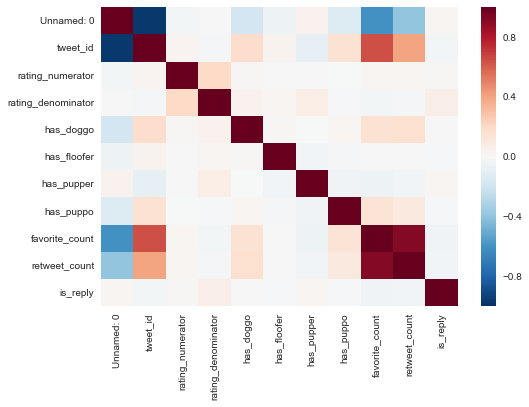

In [7]:
sns.heatmap(tweets.corr())
plt.show()

Interestingly only real correlation seems to be between favorite and retweet counts, which is intuitive. Need to dive deeper into boolean values

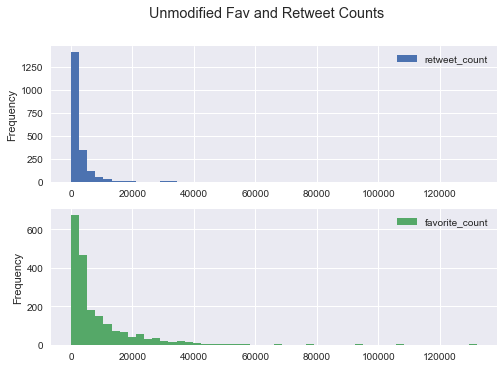

In [9]:
tweets[['retweet_count','favorite_count']].plot.hist(subplots = True, bins = 50, sharex=False , title = 'Unmodified Fav and Retweet Counts')
plt.show()

Both retweet and favorite are long tailed, left skew.

In [11]:
tweets['favorite_count_log'] = np.log(tweets.favorite_count)
tweets['retweet_count_log'] = np.log(tweets.retweet_count)
quantile_95 = tweets[(tweets.retweet_count < tweets.retweet_count.quantile(0.95)) 
                     & (tweets.favorite_count < tweets.favorite_count.quantile(0.95))]

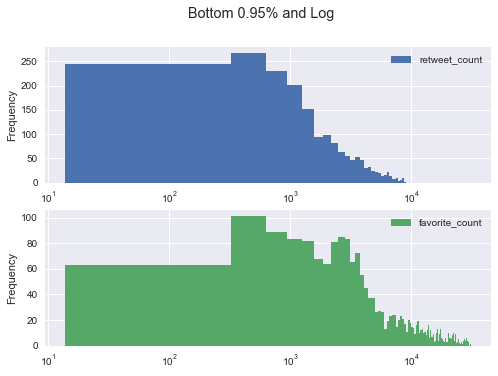

,retweet_count,favorite_count
count,1873.000000,1873.000000
mean,1898.539242,6631.169781
std,1805.080257,6869.150533
min,14.000000,81.000000
25%,597.000000,1798.000000
50%,1250.000000,3740.000000
75%,2650.000000,9383.000000
max,8957.000000,31057.000000


In [12]:
quantile_95[['retweet_count','favorite_count']].plot.hist(subplots = True, bins = 100, sharex=False , title = 'Bottom 0.95% and Log', logx = True )
plt.show()

quantile_95[['retweet_count','favorite_count']].describe()

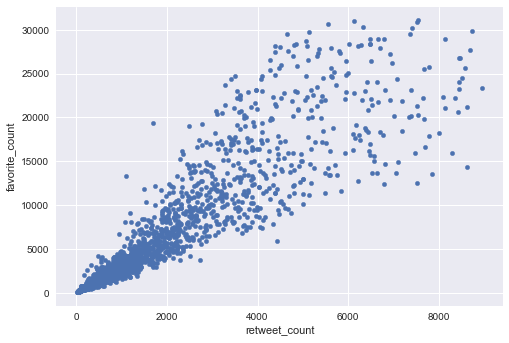

(0.90198879920294683, 0.0)


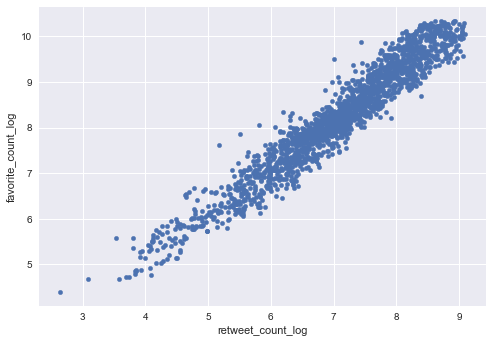

(0.96314671458237966, 0.0)


In [13]:
quantile_95[['retweet_count', 'favorite_count']].plot(
    x = 'retweet_count', y = 'favorite_count', kind = "scatter")
plt.show()
print(stats.pearsonr(quantile_95.retweet_count, quantile_95.favorite_count))

#log version
quantile_95[['retweet_count_log', 'favorite_count_log']].plot(
    x = 'retweet_count_log', y = 'favorite_count_log', kind = "scatter")
plt.show()
print(stats.pearsonr(quantile_95.retweet_count_log, quantile_95.favorite_count_log))

Strong correlation between sharing and liking behavior that becomes less robust at high values (heteroscedastic), but can be log normalized.

has_pupper median favs: 3167.5 n = 224
has_floofer median favs: 6512.0 n = 36
has_doggo median favs: 10069.0 n = 68
has_puppo median favs: 11353.0 n = 23
Total Median 3740.0


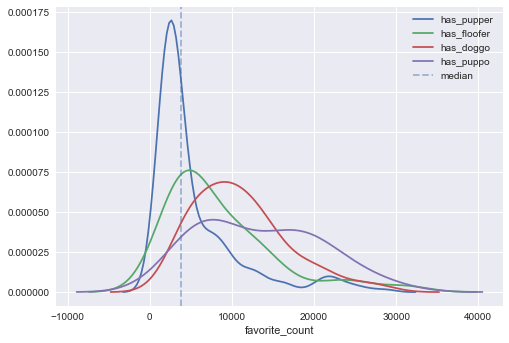

In [15]:
stage_list = ['has_pupper','has_floofer','has_doggo','has_puppo']
for stage in stage_list:
    has_x_favorites = quantile_95[(quantile_95[stage] == True)]['favorite_count']
    sns.distplot(has_x_favorites, hist = False, label = stage)
    median = has_x_favorites.median()
    print(stage,'median favs:', median, 'n =', len(has_x_favorites))

print('Total Median', quantile_95.favorite_count.median())    
plt.axvline(x = quantile_95.favorite_count.median(), alpha = 0.5, linestyle = 'dashed', label = 'median')
plt.legend(loc = 'upper right')
plt.show()

## Insight 1:
People seem to like puppos and doggos the most. But these are also those with the least about of data. Puppers tend to be smaller, doggos bigger, and puppos in between. Is this evidence for novelty increasing likes? Is there a preference for more adult or adolescent dogs? (Keep in mind small N) (include recomended experiment)

In [16]:
breed_groups = quantile_95.groupby('breed')
breed_stats = breed_groups['favorite_count'].agg(['median', 'count'])

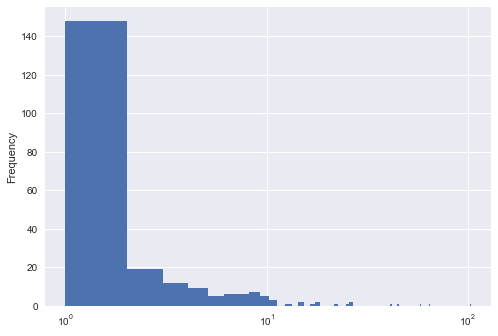

count    235.000000
mean       4.714894
std       10.125262
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max      104.000000
Name: count, dtype: float64


In [17]:
breed_stats['count'].plot.hist(bins = 100, logx = True)
plt.show()
print(breed_stats['count'].describe())

Strong right skew

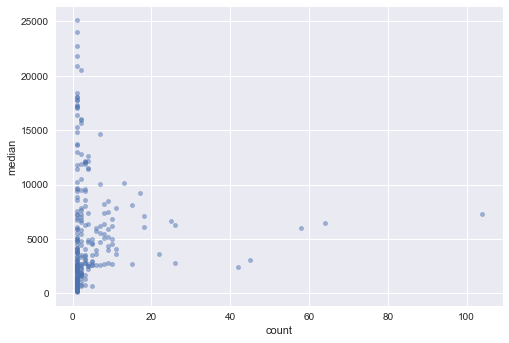

Correlation for bottom 90% of counts: (-0.015706483535603031, 0.82312979836195455)


In [18]:
breed_stats_90 = breed_stats[breed_stats['count'] < breed_stats['count'].quantile(0.90)]
breed_stats.plot(x='count',y='median', kind ="scatter", alpha = 0.5)
plt.show()
print("Correlation for bottom 90% of counts:", stats.pearsonr(breed_stats_90['count'], breed_stats_90['median']))

There is high variety of breeds. Novelty does not play a roll, but could use more data for higher counts (better classification).

In [19]:
#preference for dogs vs. non-dog posts
print('Dog Post Median Likes', quantile_95[quantile_95.is_dog == True]['favorite_count'].median())
print('n =', quantile_95[quantile_95.is_dog == True]['favorite_count'].count())
print('Non-dog Posts Median Likes', quantile_95[quantile_95.is_dog == False]['favorite_count'].median())
print('n =', quantile_95[quantile_95.is_dog == False]['favorite_count'].count())

Dog Post Median Likes 4693.0
n = 874
Non-dog Posts Median Likes 3564.5
n = 234


In [20]:
#Testing H0: uDog Favs - uNon-Dog Favs = 0, H1: uDog Favs - uNon-Dog Favs > 0
stats.ttest_ind(quantile_95[quantile_95.is_dog == True]['favorite_count_log'],
                quantile_95[quantile_95.is_dog == False]['favorite_count_log'])

Ttest_indResult(statistic=2.4517332546644708, pvalue=0.014370801268983465)

People like dog posts substantially more than non-dog posts

In [ ]:
#need to add comments and clean up last two code block before quit


/Users/ericandresen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


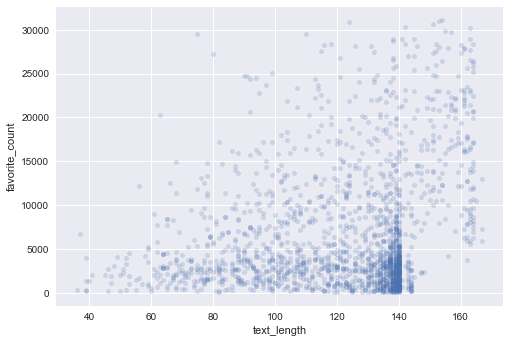

(0.23911031536902269, 9.2114916573711224e-26)

In [102]:
quantile_95['text_length'] = quantile_95.text.str.len()

quantile_95.plot.scatter(x = 'text_length', y = 'favorite_count',alpha = 0.2)
plt.show()

stats.pearsonr(quantile_95.favorite_count, quantile_95.text_length)

## Insight 2:
There is a weak correlation between text length and favorite count. There is strong clustering around 140 characters, which makes sense given that is the limit prescribed by twitter. Very low character posts tend have low favorite counts (best to be above 100 char).

Note: >140 character entries are due to character encodings (e.g. & as `&amp;`)

/Users/ericandresen/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


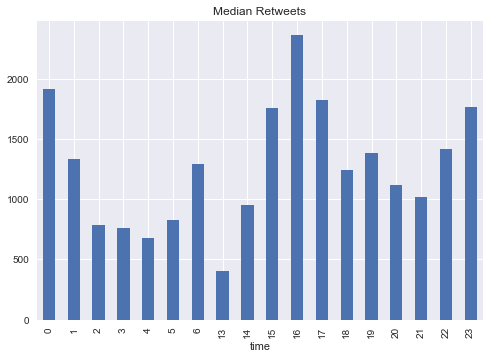

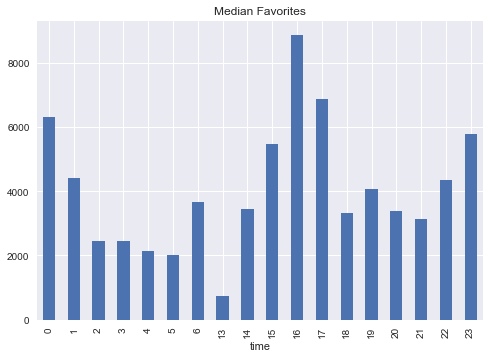

In [92]:
#Does time of day affect retweets/likes
quantile_95.time = pd.to_datetime(quantile_95.time)
tweets_by_hour = quantile_95.groupby(quantile_95.time.dt.hour)
favorites_by_hour = tweets_by_hour['favorite_count'].median()
retweets_by_hour = tweets_by_hour['retweet_count'].median()
retweets_by_hour.sort_index().plot(kind = "bar", title = 'Median Retweets')
plt.show()
favorites_by_hour.sort_index().plot(kind = "bar", title = 'Median Favorites')
plt.show()


This seems to be missing data (between 6 and 12), need to verify that data wasn't dropped

In [90]:
pd.to_datetime(tweet_scraped.time).dt.hour.value_counts().sort_index()

0     291
1     327
2     254
3     199
4     112
5      30
6       5
12      2
13      5
14      9
15     99
16    214
17    188
18    123
19    106
20     94
21     87
22     83
23    123
Name: time, dtype: int64

## Insight 3:
Either there is missing data, or more likely this corresponds to times in the United States. 6 UTC is 1 AM EST, where WeRateDogs is located and it may be that the channel does not post at night. There seems to be a periodic cycle of likes by time of day. There is a strong peak at 15 - 17 UTC (10AM to 12PM EST) and another smaller bump at 22 - 01 UTC (5PM - 8pm EST). However, there appears to be the beginning of another peak around 6 UTC (1AM EST) when the data ends, suggesting that if tweets are stopping at this time WeRateDogs is missing a window of engagement possibly in Europe where it would be early afternoon.

In [107]:
#Do Replies do Better?
is_reply = quantile_95[quantile_95.is_reply == True]
not_reply = quantile_95[quantile_95.is_reply == False]

print('is_reply:', is_reply.favorite_count.mean(), 'n =', len(is_reply))
print('not_reply:', not_reply.favorite_count.mean(), 'n =', len(not_reply))

is_reply: 4297.782608695652 n = 23
not_reply: 6660.179459459459 n = 1850


In [106]:
#test H0: u is_reply Favs - u not_reply favs = 0
#     H1: u is_reply favs - u not_reply favs < 0
stats.ttest_ind(is_reply.favorite_count, not_reply.favorite_count)

Ttest_indResult(statistic=-1.6399348341460698, pvalue=0.10118681848014303)

## Insight 4
Reply posts might actually be *less* popular than regular posts, but there needs to be more data on reply posts to be certain. (Suggest experiment)